In [162]:
import pickle
import datetime
import pandas as pd
import numpy as np
import itertools
from matplotlib import pyplot as plt
from tqdm import tqdm
from datetime import timedelta
from importlib import reload
import utils
from sklearn.compose import ColumnTransformer
import column_transforms

In [163]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [164]:
import shap
import catboost as cb
from catboost import CatBoostRegressor, EShapCalcType, EFeaturesSelectionAlgorithm

In [165]:
BASE_PATH = "/Users/thibaut/Desktop"

## Data loading

In [166]:
df = pd.read_csv(f"{BASE_PATH}/230K_hw2/features.csv", index_col=[0,1])
df.index = pd.MultiIndex.from_arrays(
    [pd.to_datetime(df.index.get_level_values(0)).date, df.index.get_level_values(1)]
)

Last five years are out of sample and a two year period preceding the out of sample period is used for validation. The ends are exclusive.


In [167]:
beginning_oos = end_validation = datetime.date(2017, 2, 28)
end_oos = datetime.date(2022, 3, 31)
beginning_validation = beginning_oos - timedelta(days=365*2)

beginning_train = df.index.get_level_values(0)[0]

In [240]:
df.loc[beginning_oos: ,:]

log_size    log_bm   log_pcf       mom     strev  \
           permno                                                      
2017-02-28 10026    7.825365 -1.283738  2.983457  0.154731  0.048836   
           10032    7.543856 -0.669431  2.318458  0.400234  0.032596   
           10104   12.070935 -1.224176  2.452383  0.101789  0.061832   
           10107   13.111115 -1.924149  2.593088  0.259474 -0.004388   
           10138    9.753629 -1.301953  4.614893  0.005577  0.055901   
...                      ...       ...       ...       ...       ...   
2022-02-28 93369    8.931354 -2.900422  3.358220 -0.150411  0.143396   
           93374    8.899731 -0.223144  1.850500  0.379581 -0.100254   
           93423    8.232892 -3.411248  2.438688 -0.121693  0.105597   
           93429    9.433748 -1.220780  2.179739  0.191814 -0.006418   
           93436   13.709701 -3.352407  4.751545  0.326930 -0.070769   

                        vol    roa    roe  log_age_lb   price  ...  \
           permno                                              ...   
2017-02-28 10026   0.045597  0.202  0.116    3.434694  133.80  ...   
           10032   0.066954  0.100  0.101    3.434694   56.07  ...   
           10104   0.045848  0.138  0.189    3.431952   42.59  ...   
           10107   0.050434  0.165  0.249    3.431952   63.98  ...   
           10138   0.044302  0.341  0.249    3.429292   71.21  ...   
...                     ...    ...    ...         ...     ...  ...   
2022-02-28 93369   0.104120  0.189  0.740    2.464378   27.19  ...   
           93374   0.066705  0.137  0.240    2.457362   67.04  ...   
           93423   0.113710  0.164  0.418    2.457362   43.66  ...   
           93429   0.060981  0.139  0.120    2.457362  117.29  ...   
           93436   0.134342  0.139  0.160    2.457362  870.43  ...   

                   roe_rel_diff  log_to_rel_diff  ols_3m_d_rel_diff  \
           permno                                                     
2017-02-28 10026      -0.027272        -1.221718           0.170229   
           10032      -0.042272        -0.918443           0.012196   
           10104       0.045728         2.821430          -0.464100   
           10107       0.105728         3.904734          -0.481017   
           10138       0.105728         1.517277          -0.006016   
...                         ...              ...                ...   
2022-02-28 93369       0.417985        -0.483945          -0.096884   
           93374      -0.082015        -0.021912          -0.039772   
           93423       0.095985         0.319671           0.222161   
           93429      -0.202015         0.382215          -0.273479   
           93436      -0.162015         5.963896           1.275476   

                   log_price  log_size_diff  log_bm_diff  log_pcf_diff  \
           permno                                                        
2017-02-28 10026    4.896346       0.047698    -0.109324      0.054132   
           10032    4.026601       0.032112    -0.134995     -0.277319   
           10104    3.751619       0.059994     0.000000      0.000000   
           10107    4.158571      -0.010417    -0.091567      0.034699   
           10138    4.265633       0.042017    -0.087930      0.814360   
...                      ...            ...          ...           ...   
2022-02-28 93369    3.302849       0.134077     0.000000      0.000000   
           93374    4.205289      -0.109558     0.000000      0.000000   
           93423    3.776432       0.102686     0.000000      0.000000   
           93429    4.764650      -0.010905     0.000000      0.000000   
           93436    6.768987      -0.073397     0.000000      0.000000   

                   log_age_lb_diff  log_price_diff  log_to_diff  
           permno                                                
2017-02-28 10026          0.002476        0.047681    -0.063355  
           10032          0.002476        0.032077     0.105779  
           10104     

# Benchmarks

In [168]:
reload(utils)

<module 'utils' from '/Users/thibaut/Desktop/230K_hw2/utils.py'>

In [169]:
df.columns

Index(['log_size', 'log_bm', 'log_pcf', 'mom', 'strev', 'vol', 'roa', 'roe',
       'log_age_lb', 'price', 'log_to', 'rf', 'rm', 'ols_3m_d', 'ols_1y_d',
       'ols_5y_m', 'f_ols_1y_d', 'market_cap', 'capm_return',
       'log_size_rel_diff', 'log_bm_rel_diff', 'log_pcf_rel_diff',
       'mom_rel_diff', 'strev_rel_diff', 'vol_rel_diff', 'roa_rel_diff',
       'roe_rel_diff', 'log_to_rel_diff', 'ols_3m_d_rel_diff', 'log_price',
       'log_size_diff', 'log_bm_diff', 'log_pcf_diff', 'log_age_lb_diff',
       'log_price_diff', 'log_to_diff'],
      dtype='object')

In [170]:
print(f"Using 5y monthly OLS for benchmark")
out_of_sample_mse = utils.mse(df, 'ols_5y_m', 'f_ols_1y_d', beginning_oos, end_oos)
out_of_sample_mape = utils.mape(df, 'ols_5y_m', 'f_ols_1y_d', beginning_oos, end_oos)
out_of_sample_wmse = utils.value_weighted_mse(df, 'ols_5y_m', 'f_ols_1y_d', beginning_oos, end_oos)
out_of_sample_wmape = utils.value_weighted_mape(df, 'ols_5y_m', 'f_ols_1y_d', beginning_oos, end_oos)
print(f"Out of sample MSE: {out_of_sample_mse}")
print(f"Out of sample MAPE: {out_of_sample_mape}")
print(f"Out of sample weighted MSE: {out_of_sample_wmse}")
print(f"Out of sample weighted MAPE: {out_of_sample_wmape}")
print("\n") 

print(f"Using 1y daily for benchmark")
out_of_sample_mse = utils.mse(df, 'ols_1y_d', 'f_ols_1y_d', beginning_oos, end_oos)
out_of_sample_mape = utils.mape(df, 'ols_1y_d', 'f_ols_1y_d', beginning_oos, end_oos)
out_of_sample_wmse = utils.value_weighted_mse(df, 'ols_1y_d', 'f_ols_1y_d', beginning_oos, end_oos)
out_of_sample_wmape = utils.value_weighted_mape(df, 'ols_1y_d', 'f_ols_1y_d', beginning_oos, end_oos)
print(f"Out of sample MSE: {out_of_sample_mse}")
print(f"Out of sample MAPE: {out_of_sample_mape}")
print(f"Out of sample weighted MSE: {out_of_sample_wmse}")
print(f"Out of sample weighted MAPE: {out_of_sample_wmape}")
print("\n") 

print(f"Using 3m daily for benchmark")
out_of_sample_mse = utils.mse(df, 'ols_3m_d', 'f_ols_1y_d', beginning_oos, end_oos)
out_of_sample_mape = utils.mape(df, 'ols_3m_d', 'f_ols_1y_d', beginning_oos, end_oos)
out_of_sample_wmse = utils.value_weighted_mse(df, 'ols_3m_d', 'f_ols_1y_d', beginning_oos, end_oos)
out_of_sample_wmape = utils.value_weighted_mape(df, 'ols_3m_d', 'f_ols_1y_d', beginning_oos, end_oos)
print(f"Out of sample MSE: {out_of_sample_mse}")
print(f"Out of sample MAPE: {out_of_sample_mape}")
print(f"Out of sample weighted MSE: {out_of_sample_wmse}")
print(f"Out of sample weighted MAPE: {out_of_sample_wmape}")

Using 5y monthly OLS for benchmark
Out of sample MSE: 0.14776963286289713
Out of sample MAPE: 38.38391911869529
Out of sample weighted MSE: 0.11212827266702116
Out of sample weighted MAPE: 34.09812077664707


Using 1y daily for benchmark
Out of sample MSE: 0.1808748894795817
Out of sample MAPE: 39.43022851528708
Out of sample weighted MSE: 0.11122707974423018
Out of sample weighted MAPE: 31.478561778962177


Using 3m daily for benchmark
Out of sample MSE: 0.28367415894309234
Out of sample MAPE: 44.842843730012994
Out of sample weighted MSE: 0.14992244096300256
Out of sample weighted MAPE: 34.23614577135323


We can't do a ticker wise time series regression, becasue of high dimensionality (and overfitting issue), we must resort to a full regression across all tickers and dates.


# Train/validation/test(oos) split

In [171]:
print(df.columns)


Index(['log_size', 'log_bm', 'log_pcf', 'mom', 'strev', 'vol', 'roa', 'roe',
       'log_age_lb', 'price', 'log_to', 'rf', 'rm', 'ols_3m_d', 'ols_1y_d',
       'ols_5y_m', 'f_ols_1y_d', 'market_cap', 'capm_return',
       'log_size_rel_diff', 'log_bm_rel_diff', 'log_pcf_rel_diff',
       'mom_rel_diff', 'strev_rel_diff', 'vol_rel_diff', 'roa_rel_diff',
       'roe_rel_diff', 'log_to_rel_diff', 'ols_3m_d_rel_diff', 'log_price',
       'log_size_diff', 'log_bm_diff', 'log_pcf_diff', 'log_age_lb_diff',
       'log_price_diff', 'log_to_diff'],
      dtype='object')


In [172]:
reload(column_transforms)

<module 'column_transforms' from '/Users/thibaut/Desktop/230K_hw2/column_transforms.py'>

In [173]:
def train_validation(df, model, L_features, target_name, preprocessor, beginning_train, beginning_validation, end_validation):
    
    df_X_train = df.loc[beginning_train:beginning_validation, L_features]
    df_X_train_transformed = preprocessor.fit_transform(df_X_train)
    df_y_train = df.loc[beginning_train:beginning_validation, target_name]

    model.fit(df_X_train_transformed, df_y_train)
    df_X_forecast = df.loc[beginning_validation:end_validation, L_features]
    df_X_forecast_transformed = preprocessor.transform(df_X_forecast)

    train_forecast = pd.Series(model.predict(df_X_train_transformed),  index = df_X_train.index)
    validation_forecast = pd.Series(model.predict(df_X_forecast_transformed),  index = df_X_forecast.index)

    df['forecast'] = pd.concat([train_forecast, validation_forecast], axis=0)

    mse_train = utils.mse(df, 'forecast', 'f_ols_1y_d', beginning_train, beginning_validation)
    mape_train =  utils.mape(df, 'forecast', 'f_ols_1y_d', beginning_train, beginning_validation)
    w_mse_train = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', beginning_train, beginning_validation)
    w_mape_train = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', beginning_train, beginning_validation)

    mse_val = utils.mse(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
    mape_val =  utils.mape(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
    w_mse_val = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
    w_mape_val = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)

    df_metrics = pd.DataFrame({"MSE_train": [mse_train],"MSE_val": [mse_val], "MAPE_train": [mape_train], "MAPE_val": [mape_val], "WMSE_train":[w_mse_train], "WMSE_val":[w_mse_val], "WMAPE_train":[w_mape_train],"WMAPE_val":[w_mape_val]})


    return df_metrics, df[['forecast']]

# Models and hyperparameter tuning

### Linear Regression

In [13]:
L_features_volnorm = df.filter(like="rel_diff").columns.to_list()
L_features_znorm = df.columns.to_list()
L_features_znorm.remove("f_ols_1y_d")
for feat in L_features_volnorm:
    L_features_znorm.remove(feat)

L_features = L_features_znorm+L_features_volnorm
target_name =  'f_ols_1y_d'

lr_model = LinearRegression(fit_intercept=True)
preprocessor = ColumnTransformer([
    ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=21, ewm_period_std_dev=21), L_features_znorm),
    ('volnorm', column_transforms.VolScaler(ewm_period_std_dev=21), L_features_volnorm),  
    ('winsorize', column_transforms.Winsorizer(), L_features),         
], remainder = 'passthrough')

In [14]:
df_res_lr, df_forecast_lr = train_validation(df, lr_model, L_features, target_name, preprocessor, beginning_train, beginning_validation, end_validation)
df_res_lr["model"] = ["lr"]

In [26]:
df_res_lr

,MSE_train,MSE_val,MAPE_train,MAPE_val,WMSE_train,WMSE_val,WMAPE_train,WMAPE_val,model
0,0.121019,0.192412,37.835262,29.848019,0.081458,0.082829,25.667962,25.841428,lr


### Lasso Regression

In [74]:
L_features_volnorm = df.filter(like="rel_diff").columns.to_list()
L_features_znorm = df.columns.to_list()
L_features_znorm.remove("f_ols_1y_d")
for feat in L_features_volnorm:
    L_features_znorm.remove(feat)

L_features = L_features_znorm+L_features_volnorm
target_name =  'f_ols_1y_d'


alphas = np.logspace(-3, 0, 10)  
lasso_cv = LassoCV(alphas=alphas, cv=5, fit_intercept=True, n_jobs=-1)
preprocessor = ColumnTransformer([
    ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=21, ewm_period_std_dev=21), L_features_znorm),
    ('volnorm', column_transforms.VolScaler(ewm_period_std_dev=21), L_features_volnorm),  
    ('winsorize', column_transforms.Winsorizer(), L_features),         
], remainder = 'passthrough')

In [75]:
df_res_lasso, df_forecast_lasso = train_validation(df, lasso_cv, L_features, target_name, preprocessor, 
                                             beginning_train, beginning_validation, end_validation)

df_res_lasso["model"] = ["lasso"]

In [76]:
df_res_lasso

,MSE_train,MSE_val,MAPE_train,MAPE_val,WMSE_train,WMSE_val,WMAPE_train,WMAPE_val,model
0,0.122,0.168773,37.81472,28.611141,0.080765,0.077029,25.342115,25.798405,lasso


### Random Forest

In [14]:
L_features = df.columns.to_list()
L_features.remove("f_ols_1y_d")
target_name = "f_ols_1y_d"

preprocessor = ColumnTransformer([
    ('winsorize', column_transforms.Winsorizer(), L_features),  
], remainder='passthrough')


param_grid_rf = {
    'n_estimators': [100, 300],
    'max_depth': [3, 7],
    'min_samples_split': [2, 5]
}


results_dict_rf = {}


for params in tqdm(itertools.product(*param_grid_rf.values()), total=np.prod([len(v) for v in param_grid_rf.values()]), desc="Training Random Forest Models"):

    model_params = dict(zip(param_grid_rf.keys(), params))
    rf_model = RandomForestRegressor(**model_params, random_state=42)

    df_metrics_rf, df_forecast_rf = train_validation(df, rf_model, L_features, target_name, preprocessor, 
                                                     beginning_train, beginning_validation, end_validation)


    results_dict_rf[f"model_{len(results_dict_rf) + 1}"] = {
        'parameters': model_params,
        'metrics': df_metrics_rf,
        'forecast': df_forecast_rf,
        'preprocessor': preprocessor, 
        'features': L_features
    }

Training Random Forest Models:   0%|          | 0/8 [00:00<?, ?it/s]

Training Random Forest Models: 100%|██████████| 8/8 [6:34:52<00:00, 2961.57s/it]  


with open("results_rf.pkl", "wb") as f:
    pickle.dump(results_dict_rf, f)

In [230]:
with open("results_rf.pkl", "rb") as f:
    results_rf = pickle.load(f)

In [47]:
L_res_rf = []
for key in results_rf.keys():
    el = results_rf[key]
    df_res = el["metrics"]
    df_res["model"] = [key]
    L_res_rf.append(df_res)

df_res_rf= pd.concat(L_res_rf, axis=0)

In [58]:
df_res_rf.sort_values(by="WMAPE_val", ascending=True, inplace=True)
df_res_rf

,MSE_train,MSE_val,MAPE_train,MAPE_val,WMSE_train,WMSE_val,WMAPE_train,WMAPE_val,model
0,0.119933,0.159466,38.392012,28.716633,0.078274,0.075658,25.010092,26.191863,model_3
0,0.119933,0.159466,38.392012,28.716633,0.078274,0.075658,25.010092,26.191863,model_4
0,0.119841,0.159702,38.382775,28.735951,0.078234,0.075684,25.013175,26.226196,model_7
0,0.119841,0.159702,38.382775,28.735951,0.078234,0.075684,25.013175,26.226196,model_8
0,0.138486,0.166998,41.930129,28.843073,0.088948,0.078795,26.269215,26.440569,model_1
0,0.138486,0.166998,41.930129,28.843073,0.088948,0.078795,26.269215,26.440569,model_2
0,0.138413,0.166946,41.928660,28.844289,0.088901,0.078791,26.269053,26.445279,model_5
0,0.138413,0.166946,41.928660,28.844289,0.088901,0.078791,26.269053,26.445279,model_6


In [61]:
df_res_rf = df_res_rf.iloc[0:1]
df_res_rf["model"] = ["rf"]
df_res_rf

,MSE_train,MSE_val,MAPE_train,MAPE_val,WMSE_train,WMSE_val,WMAPE_train,WMAPE_val,model
0,0.119933,0.159466,38.392012,28.716633,0.078274,0.075658,25.010092,26.191863,rf


#### XGBoost

In [ ]:
L_features = df.columns.to_list()
L_features.remove("f_ols_1y_d")
target_name =  'f_ols_1y_d'

preprocessor = ColumnTransformer([
    ('winsorize', column_transforms.Winsorizer(), L_features),  
], remainder = 'passthrough')


param_grid_xgb= {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

results_dict_xgb = {}

for params in tqdm(itertools.product(*param_grid_xgb.values()), total=np.prod([len(v) for v in param_grid_xgb.values()]), desc="Training Models"):

    model_params = dict(zip(param_grid_xgb.keys(), params))
    xgb_model = xgb.XGBRegressor(**model_params)

    df_metrics_xgb, df_forecast_xgb = train_validation(df, xgb_model, L_features, target_name, preprocessor, 
                                                       beginning_train, beginning_validation, end_validation)

    results_dict_xgb[f"model_{len(results_dict_xgb) + 1}"] = {
        'parameters': model_params,
        'metrics': df_metrics_xgb,
        'forecast': df_forecast_xgb,
         'preprocessor': preprocessor, 
        'features': L_features
    }

Training Models:   0%|          | 0/27 [00:00<?, ?it/s]

Training Models: 100%|██████████| 27/27 [11:14<00:00, 24.99s/it]


with open("results_xgb.pkl", "wb") as f:
    pickle.dump(results_dict_xgb, f)

In [233]:
with open("results_xgb.pkl", "rb") as f:
    results_xgb = pickle.load(f)

In [49]:
L_res_xgb = []
for key in results_xgb.keys():
    el = results_xgb[key]
    df_res = el["metrics"]
    df_res["model"] = [key]
    L_res_xgb.append(df_res)

df_res_xgb = pd.concat(L_res_xgb, axis=0)

In [62]:
df_res_xgb.sort_values(by="WMAPE_val", ascending=True, inplace=True)
df_res_xgb

,MSE_train,MSE_val,MAPE_train,MAPE_val,WMSE_train,WMSE_val,WMAPE_train,WMAPE_val,model
0,0.099114,0.172381,33.958840,28.954270,0.064567,0.080375,22.722520,25.888313,model_8
0,0.103574,0.169218,34.596133,28.924836,0.067574,0.079680,23.094165,26.096453,model_7
0,0.109011,0.164017,35.935025,28.774299,0.070818,0.077457,23.822756,26.166214,model_5
0,0.101613,0.167166,34.688619,28.823549,0.065820,0.079100,23.090003,26.257069,model_6
0,0.113924,0.161996,36.800966,28.817338,0.074514,0.076752,24.298458,26.328408,model_4
0,0.090006,0.175713,32.593676,29.189016,0.058616,0.082299,21.803976,26.443377,model_9
0,0.092313,0.176712,32.483899,29.400749,0.060563,0.083575,21.759022,26.621954,model_13
0,0.089540,0.177165,32.184905,29.527748,0.058617,0.084431,21.584865,27.038866,model_14
0,0.082759,0.177586,31.224906,29.627837,0.054040,0.085316,20.884636,27.281167,model_15
0,0.085839,0.179318,31.340658,29.792903,0.056018,0.086872,20.910482,27.507137,model_16


In [234]:
results_xgb["model_8"]

{'parameters': {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5},
 'metrics':    MSE_train   MSE_val  MAPE_train  MAPE_val  WMSE_train  WMSE_val  \
 0   0.099114  0.172381    33.95884  28.95427    0.064567  0.080375   
 
    WMAPE_train  WMAPE_val  
 0     22.72252  25.888313  ,
 'forecast':                    forecast
            permno          
 1970-03-31 10006   0.846441
            10102   1.057906
            10137   0.736685
            10145   1.034371
            10153   1.001991
 ...                     ...
 2022-02-28 93369        NaN
            93374        NaN
            93423        NaN
            93429        NaN
            93436        NaN
 
 [793628 rows x 1 columns],
 'preprocessor': ColumnTransformer(remainder='passthrough',
                   transformers=[('winsorize', Winsorizer(),
                                  ['log_size', 'log_bm', 'log_pcf', 'mom',
                                   'strev', 'vol', 'roa', 'roe', 'log_age_lb',
                

In [66]:
df_res_xgb = df_res_xgb.iloc[0:1]
df_res_xgb["model"] = ["xgb"]
df_res_xgb

,MSE_train,MSE_val,MAPE_train,MAPE_val,WMSE_train,WMSE_val,WMAPE_train,WMAPE_val,model
0,0.099114,0.172381,33.95884,28.95427,0.064567,0.080375,22.72252,25.888313,xgb


# LSTM

In [193]:
L_features = df.columns.to_list()
L_features.remove("f_ols_1y_d")
target_name = "f_ols_1y_d"

preprocessor = ColumnTransformer([
    ('winsorize', column_transforms.Winsorizer(), L_features),  
], remainder='passthrough')

seq_length = 10 
lstm_model = Sequential([
    LSTM(50, activation="relu", return_sequences=False, input_shape=(seq_length, 1)),
    Dense(1)  # Output layer
])

lstm_model.compile(optimizer="adam", loss="mse")

/Users/thibaut/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [194]:
df_X_train = df.loc[beginning_train:beginning_validation, L_features]
df_X_train_transformed = preprocessor.fit_transform(df_X_train)
df_y_train = df.loc[beginning_train:beginning_validation, target_name]
lstm_model.fit(df_X_train_transformed, df_y_train)
df_X_forecast = df.loc[beginning_validation:end_validation, L_features]
df_X_forecast_transformed = preprocessor.transform(df_X_forecast)

20783/20783 ━━━━━━━━━━━━━━━━━━━━ 340s 16ms/step - loss: 2.4444


In [195]:
train_forecast = lstm_model.predict(df_X_train_transformed)
train_forecast = pd.Series(train_forecast.flatten(),  index = df_X_train.index)

validation_forecast = lstm_model.predict(df_X_forecast_transformed)
validation_forecast = pd.Series(validation_forecast.flatten(),  index = df_X_forecast.index)

20783/20783 ━━━━━━━━━━━━━━━━━━━━ 125s 6ms/step
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step


In [196]:
df_lstm = df.copy()
df_lstm['forecast'] = pd.concat([train_forecast, validation_forecast], axis=0)

In [207]:
mse_train = utils.mse(df_lstm, 'forecast', 'f_ols_1y_d', beginning_train, beginning_validation)
mape_train =  utils.mape(df_lstm, 'forecast', 'f_ols_1y_d', beginning_train, beginning_validation)
w_mse_train = utils.value_weighted_mse(df_lstm, 'forecast', 'f_ols_1y_d', beginning_train, beginning_validation)
w_mape_train = utils.value_weighted_mape(df_lstm, 'forecast', 'f_ols_1y_d', beginning_train, beginning_validation)

mse_val = utils.mse(df_lstm, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
mape_val =  utils.mape(df_lstm, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
w_mse_val = utils.value_weighted_mse(df_lstm, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
w_mape_val = utils.value_weighted_mape(df_lstm, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)

df_res_lstm = pd.DataFrame({"MSE_train": [mse_train],"MSE_val": [mse_val], "MAPE_train": [mape_train], "MAPE_val": [mape_val], "WMSE_train":[w_mse_train], "WMSE_val":[w_mse_val], "WMAPE_train":[w_mape_train],"WMAPE_val":[w_mape_val]})
df_res_lstm["model"] = ["lstm"]

In [208]:
df_res_lstm

,MSE_train,MSE_val,MAPE_train,MAPE_val,WMSE_train,WMSE_val,WMAPE_train,WMAPE_val,model
0,0.137572,0.16604,40.867455,32.222213,0.109116,0.110498,32.906015,37.665936,lstm


# Additional model: CatBoost

In [105]:
L_features = df.columns.to_list()
L_features.remove("f_ols_1y_d")
target_name = "f_ols_1y_d"

In [106]:
df_X_train = df.loc[beginning_train:beginning_validation, L_features]
df_y_train = df.loc[beginning_train:beginning_validation, target_name]

df_X_validation = df.loc[beginning_validation:end_validation, L_features]
df_y_validation = df.loc[beginning_validation:end_validation, target_name]

train_pool = cb.Pool(df_X_train, df_y_train)
validation_pool  = cb.Pool(df_X_validation, df_y_validation)

In [108]:
catboost_model = cb.CatBoostRegressor(loss_function="RMSE", verbose=False)
catboost_model.fit(train_pool, eval_set=validation_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [109]:
train_forecast = pd.Series(catboost_model.predict(train_pool),  index = df_X_train.index)
validation_forecast = pd.Series(catboost_model.predict(validation_pool),  index = df_X_validation.index)

df_catboost = df.copy()
df_catboost['forecast'] = pd.concat([train_forecast, validation_forecast], axis=0)

mse_train = utils.mse(df_catboost, 'forecast', 'f_ols_1y_d', beginning_train, beginning_validation)
mape_train =  utils.mape(df_catboost, 'forecast', 'f_ols_1y_d', beginning_train, beginning_validation)
w_mse_train = utils.value_weighted_mse(df_catboost, 'forecast', 'f_ols_1y_d', beginning_train, beginning_validation)
w_mape_train = utils.value_weighted_mape(df_catboost, 'forecast', 'f_ols_1y_d', beginning_train, beginning_validation)

mse_val = utils.mse(df_catboost, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
mape_val =  utils.mape(df_catboost, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
w_mse_val = utils.value_weighted_mse(df_catboost, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
w_mape_val = utils.value_weighted_mape(df_catboost, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)

df_res_catboost = pd.DataFrame({"MSE_train": [mse_train],"MSE_val": [mse_val], "MAPE_train": [mape_train], "MAPE_val": [mape_val], "WMSE_train":[w_mse_train], "WMSE_val":[w_mse_val], "WMAPE_train":[w_mape_train],"WMAPE_val":[w_mape_val]})
df_res_catboost["model"] = ["catboost"]

In [110]:
df_res_catboost

,MSE_train,MSE_val,MAPE_train,MAPE_val,WMSE_train,WMSE_val,WMAPE_train,WMAPE_val,model
0,0.104903,0.155064,35.189524,28.095324,0.068381,0.075721,23.619375,25.502699,catboost


# Model selection

In [209]:
L_res = [df_res_lr, df_res_lasso, df_res_rf, df_res_xgb, df_res_catboost, df_res_lstm]
df_res = pd.concat(L_res, axis=0)
df_res.sort_values(by="WMAPE_val", ascending=True, inplace=True)
df_res

,MSE_train,MSE_val,MAPE_train,MAPE_val,WMSE_train,WMSE_val,WMAPE_train,WMAPE_val,model
0,0.104903,0.155064,35.189524,28.095324,0.068381,0.075721,23.619375,25.502699,catboost
0,0.122000,0.168773,37.814720,28.611141,0.080765,0.077029,25.342115,25.798405,lasso
0,0.121019,0.192412,37.835262,29.848019,0.081458,0.082829,25.667962,25.841428,lr
0,0.099114,0.172381,33.958840,28.954270,0.064567,0.080375,22.722520,25.888313,xgb
0,0.119933,0.159466,38.392012,28.716633,0.078274,0.075658,25.010092,26.191863,rf
0,0.137572,0.166040,40.867455,32.222213,0.109116,0.110498,32.906015,37.665936,lstm


# Interpretation of the best model (CatBoost for the moment)

### Feature importance based on variance reduction

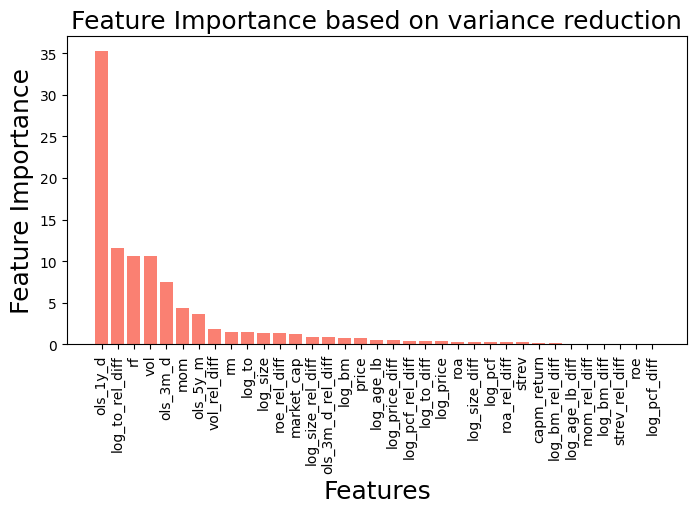

In [111]:
plt.figure(figsize=(8, 4))

sorted_feature_importance = catboost_model.feature_importances_.argsort()[::-1]

plt.bar(df_X_train.columns[sorted_feature_importance], 
        catboost_model.feature_importances_[sorted_feature_importance], 
        color='salmon')

plt.xticks(rotation=90)
plt.ylabel('Feature Importance', fontsize=18)
plt.xlabel('Features', fontsize=18)
plt.title('Feature Importance based on variance reduction', fontsize=18)

plt.show()

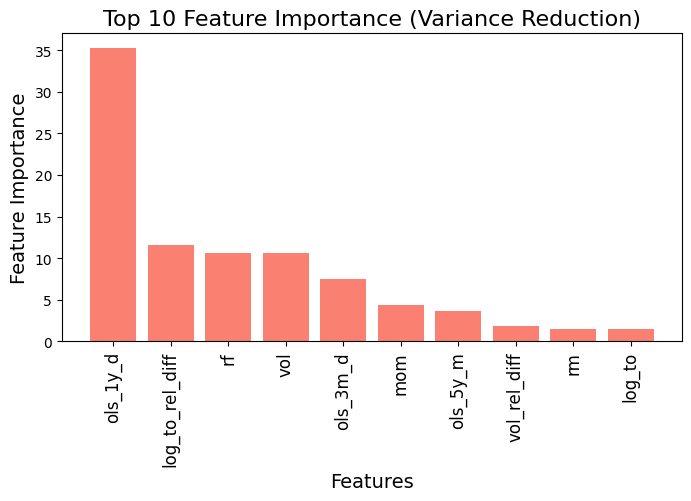

In [112]:
sorted_feature_importance = catboost_model.feature_importances_.argsort()[::-1]

# Select top 10 features
top_n = 10
top_features = df_X_train.columns[sorted_feature_importance][:top_n]
top_importances = catboost_model.feature_importances_[sorted_feature_importance][:top_n]

# Plot top 10 features
plt.figure(figsize=(8, 4))
plt.bar(top_features, top_importances, color='salmon')

plt.xticks(rotation=90, fontsize=12)
plt.ylabel('Feature Importance', fontsize=14)
plt.xlabel('Features', fontsize=14)
plt.title('Top 10 Feature Importance (Variance Reduction)', fontsize=16)

plt.show()

### Feature importance: SHAP values

In [113]:
explainer = shap.Explainer(catboost_model)
shap_values = explainer(df_X_train)

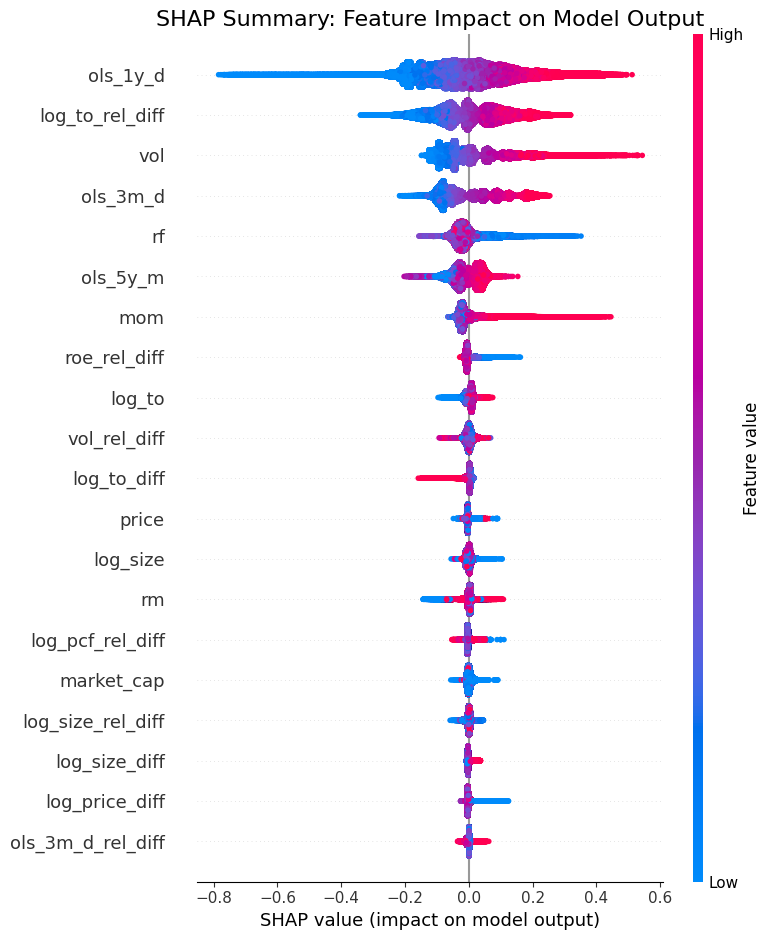

In [114]:
plt.title('SHAP Summary: Feature Impact on Model Output', fontsize=16)
shap.summary_plot(shap_values, df_X_train)

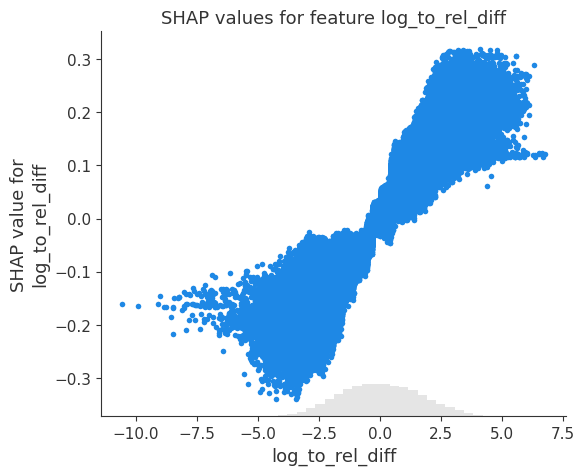

In [217]:
feature = "log_to_rel_diff"
shap.plots.scatter(shap_values[:, feature], title= "SHAP values for feature log_to_rel_diff")

# Feature selection for the best model (Catboost)

In [202]:
model = CatBoostRegressor(iterations=900, random_seed=0)
summary = model.select_features(
    train_pool,
    eval_set=validation_pool,
    features_for_select='0-34', 
    num_features_to_select=1,  
    steps=1, 
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True, # The only parameter that can be selected based on cross-validation is the number of iterations. Select the best iteration based on the information of the cv results and train the final model with this number of iterations.
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# OOS forecast using our best model (Catboost)

In [140]:
df_X_testoos = df.loc[beginning_oos:, L_features]
df_y_testoos = df.loc[beginning_oos:, target_name]

testoos_pool = cb.Pool(df_X_testoos, df_y_testoos)

testoos_forecast = pd.DataFrame(catboost_model.predict(testoos_pool),  index = df_X_testoos.index, columns=["forecast"])
df_true = pd.DataFrame(df_y_testoos, columns=["f_ols_1y_d"])
df_oos_res = pd.concat([testoos_forecast, df_true, df[["market_cap"]]], join="inner", axis=1)

In [143]:
mse_oos = utils.mse(df_oos_res, 'forecast', 'f_ols_1y_d', beginning_oos, end_oos)
mape_oos =  utils.mape(df_oos_res, 'forecast', 'f_ols_1y_d', beginning_oos, end_oos)
w_mse_oos = utils.value_weighted_mse(df_oos_res, 'forecast', 'f_ols_1y_d', beginning_oos, end_oos)
w_mape_oos = utils.value_weighted_mape(df_oos_res, 'forecast', 'f_ols_1y_d', beginning_oos, end_oos)
df_res_oos = pd.DataFrame({"MSE_oos": [mse_oos], "MAPE_oos": [mape_oos], "WMSE_oos":[w_mse_oos], "WMAPE_oos":[w_mape_oos]})

In [144]:
df_res_oos

,MSE_oos,MAPE_oos,WMSE_oos,WMAPE_oos
0,0.127325,36.423796,0.080714,30.155864


# OOS Benchmark

In [228]:
L = []

for col in ['ols_3m_d', 'ols_1y_d', 'ols_5y_m']: 

    mse_oos = utils.mse(df, col, 'f_ols_1y_d', beginning_oos, end_oos)
    mape_oos =  utils.mape(df, col, 'f_ols_1y_d', beginning_oos, end_oos)
    w_mse_oos = utils.value_weighted_mse(df, col, 'f_ols_1y_d', beginning_oos, end_oos)
    w_mape_oos = utils.value_weighted_mape(df, col, 'f_ols_1y_d', beginning_oos, end_oos)
    df_res_oos = pd.DataFrame({"MSE_oos": [mse_oos], "MAPE_oos": [mape_oos], "WMSE_oos":[w_mse_oos], "WMAPE_oos":[w_mape_oos]})
    df_res_oos["benchmark"] = [col]
    L.append(df_res_oos)

df_benchmark = pd.concat(L, axis=0)

In [229]:
df_benchmark

,MSE_oos,MAPE_oos,WMSE_oos,WMAPE_oos,benchmark
0,0.283674,44.842844,0.149922,34.236146,ols_3m_d
0,0.180875,39.430229,0.111227,31.478562,ols_1y_d
0,0.147770,38.383919,0.112128,34.098121,ols_5y_m
